# 期末作业二
# 美国西储大学轴承分类

第二份作业的数据在Bearing fault data set文件夹下，总计10类故障数据，每类数据存放于1子文件夹中，每个子文件夹下有名称为“x-num.mat”（num为标号数字）的mat文件，可用scipy包模块io下的loadmat函数读入内存，每个数据长度为78400。然后编写函数进行数据分割，把数据分成长度为784的100个样本。对每一类故障建立100个样本，10类总计1000个样本。然后依据Pytorch数据集的设计规则，参考Pokemon数据设计案例，设计数据集类。其次，构建深度学习分类模型，模型中至少包括4层神经网络，Epoch次数不大于100次，调试网络结构和超参数直到模型到达自己认为可提交的状态（最后的测试精度由助教在私有数据集上评估确定）
最后，撰写程序文档，包括1个解决问题的流程图，数据集的设计思路，深度模型结构描述，训练过程的损失函数曲线图和分类精度图等。

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import pandas as pd
import os
import random

## 准备数据 refer to MINST dataset 

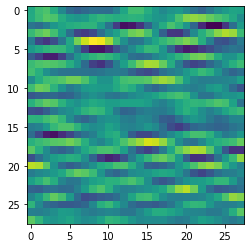

In [51]:
#尝试读取数据
x0=sio.loadmat("Bearing fault data set/data/x0.mat", mdict=None, appendmat=True)
#读取normal的数据
a=x0.get('x0')
b=a.reshape(100,28,28)
c=b[0,...]
figure = plt.figure()
plt.imshow(c)
plt.show()

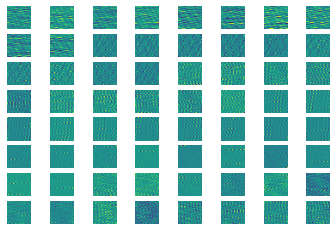

In [52]:
#由于测试集为随机从每个样本中抽取30个
#从0～99中随机选择30个元素作为下面test_data抽取数字的索引
rand=np.random.randint(0,99,30)

#批量读取数据
filepath='Bearing fault data set/data/'
mats=os.listdir(filepath)#读取文件
mats=sorted(mats)#将文件名称进行排序
train_data=b
test_data=b[rand]

#进行循环
for i in mats[1:]: #this read data from second one because x0 has been readed
  x=sio.loadmat(filepath+i, mdict=None, appendmat=True)#读出数据
  a=x.get(i[0:2])
  b=a.reshape(100,28,28)
  train_data=np.vstack((train_data,b))#让他们相加的到train_data
  test_data=np.vstack((test_data,b[rand]))#每个样本取30个元素相加到test_data

#画出一些数据
figure = plt.figure()
for i in range(64):
    plt.subplot(8,8, i+1)
    j=i*10
    c = train_data[j,...] # 取出一个图片的数据
    plt.imshow(c)
    plt.axis('off')
plt.show()

#将数据扩充张量到4维
train_data=np.expand_dims(train_data,axis=1)
test_data=np.expand_dims(test_data,axis=1)

# 构造标签集
labels=np.arange(0,10,1)
train_labels=np.repeat(labels,100)
test_labels=np.repeat(labels,30)

#将数据转化为tensor类型
train_data=torch.from_numpy(train_data).to(torch.float32)
test_data=torch.from_numpy(test_data).to(torch.float32)
train_labels=torch.from_numpy(train_labels).long()
test_labels=torch.from_numpy(test_labels).long()

#https://blog.csdn.net/ttdxtt/article/details/112347283
#原本是64位，要转为32位float

In [53]:
#构造dataset
train_dataset=TensorDataset(train_data,train_labels)
test_dataset=TensorDataset(test_data,test_labels)
#通过dataloader构建数据集
batchsz=15
train_loader=DataLoader(dataset=train_dataset,batch_size=batchsz,shuffle=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=batchsz,shuffle=True)

## 建立深度学习模型  use CNN,with 2 conv2d and 3 fc

In [57]:
# 超参数配置
epoches = 100 # 迭代次
batch_size=64  # mini-batch 数据块的尺寸大小
learning_rate = 0.01  # 梯度下降算法的学习率

# 深度卷积网络模型设计
class Flatten(nn.Module):
    '''
    定义展平运算，为卷积层输出和全连接层的输入进行数据转换
    '''
    def __init__(self):
        super(Flatten,self).__init__()
        
    def forward(self,input):
        return input.view(input.size(0),-1)


class DeepConvolutionNetwork(nn.Module):
    def __init__(self):
        super(DeepConvolutionNetwork,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=10,kernel_size=5,stride=1,padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=10,out_channels=20,kernel_size=5,stride=1,padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.FlattenOperation = Flatten()
        
        
        self.fc = nn.Sequential(
            nn.Linear(500,60),
            nn.ReLU(),
            nn.Linear(60,20),
            #nn.Dropout(0.5), don't use Dropout in this dataset
            nn.ReLU(),
            nn.Linear(20,10)
            )
    
    def forward(self,x):
      x= self.conv(x)  
      x= self.FlattenOperation(x)
      x= self.fc(x)
      return F.log_softmax(x,dim=1)



model = DeepConvolutionNetwork()
lossfun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9, 0.99))
#print(model)



lossRecord = []
for epoch in range(epoches):
    model.train() 
    for batch_idx, (x,label) in enumerate(train_loader):
        #x,label = x.to(device), label.to(device)
        logits = model(x)
        loss = lossfun(logits,label)
        lossRecord.append(loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch:{}\tLoss: {:.6f}'.format(
                epoch, loss.item() ),end='\t')
    
    model.eval()
    with torch.no_grad():
        test_correct = 0
        total_num = 0
        for x, label in test_loader:
            #x,label = x.to(device), label.to(device)
            
            logits = model(x)
            pred = logits.argmax(dim =1)
            test_correct += torch.eq(pred,label).float().sum().item()
            total_num += x.size(0)
        
        acc = test_correct / total_num
        print('acc:', acc)
        if acc>=0.95: break  #early stop



Train Epoch:0	Loss: 2.325442	acc: 0.35333333333333333
Train Epoch:1	Loss: 1.532825	acc: 0.51
Train Epoch:2	Loss: 1.731638	acc: 0.53
Train Epoch:3	Loss: 1.102792	acc: 0.7266666666666667
Train Epoch:4	Loss: 0.634389	acc: 0.6833333333333333
Train Epoch:5	Loss: 0.732658	acc: 0.7666666666666667
Train Epoch:6	Loss: 0.534610	acc: 0.7966666666666666
Train Epoch:7	Loss: 0.399650	acc: 0.81
Train Epoch:8	Loss: 0.364094	acc: 0.77
Train Epoch:9	Loss: 0.563164	acc: 0.78
Train Epoch:10	Loss: 0.523712	acc: 0.81
Train Epoch:11	Loss: 0.374480	acc: 0.86
Train Epoch:12	Loss: 0.176894	acc: 0.89
Train Epoch:13	Loss: 0.116134	acc: 0.8266666666666667
Train Epoch:14	Loss: 0.179711	acc: 0.87
Train Epoch:15	Loss: 0.453741	acc: 0.92
Train Epoch:16	Loss: 0.240428	acc: 0.96


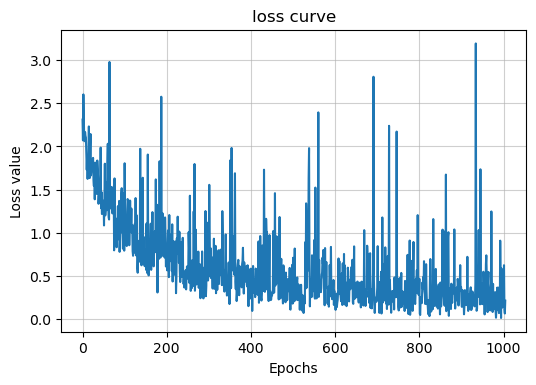

In [45]:
# 绘制损失曲线
figure = plt.figure(figsize = (6,4), dpi=100)
plt.plot(np.arange(len(lossRecord)),lossRecord)
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('loss curve')
plt.grid(alpha=0.6)
plt.show()